In [140]:
import os
import pandas as pd

In [5]:
temporal_motif_extractor_path = "/home/aakyildiz/snap/examples/temporalmotifs/temporalmotifsmain"

# Extract temporal motifs from a graph 

In [166]:
def extract_temporal_motifs(input_graph_path, numThreads=32, delta=60):
    #parameters
    numThreads = str(numThreads)
    delta = str(delta)

    out_path = input_graph_path.split(".")[0] + "-delta=" + delta + ".temporalmotifs"
    command = temporal_motif_extractor_path + " -i:" + input_graph_path \
                                            + " -nt:"  + numThreads\
                                            + " -delta:"  + delta\
                                            + " -o:" + out_path
    #print(command)
    res = os.popen(command)
    res.read()
    motifs = []
    with open(out_path, "r") as f:
        for line in f:
            counts = line.replace("\n", "").split(" ")
            motifs.append([int(count) for count in counts])
    return motifs

# Motif heatmap viewer

In [175]:
def display_motifs_heatmap(motifs, image_path=None, figname=None, title=None):
    # open the image 
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import seaborn as sns
    # Import image and get x and y extents
    
    cmap = plt.cm.get_cmap('Blues', len(np.unique(motifs)))
    if image_path is not None:
        img = plt.imread(image_path)
        x_ext = img.shape[1]/100.0
        y_ext = img.shape[0]/100.0
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        ax2.imshow(img, alpha=1, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.imshow(motifs, cmap=cmap, alpha = 0.3, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.set_aspect('equal')
    else:
        fig, ax1 = plt.subplots()
    yticklabels = [str(i) for i in reversed(range(len(motifs)))]
    sns.heatmap(motifs, cmap=cmap, annot=True, fmt="d", ax=ax1, yticklabels=yticklabels)    
    ax1.set_aspect('equal')
    fig.set_size_inches(12,5)
    if title is not None:
        fig.suptitle(title, fontsize=20)
    plt.show()
    if figname != None:
        fig.savefig(figname, dpi=300, bbox_inches='tight')


# Evolutionary temporal viewer

In [187]:
def evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=60):
    graph = pd.read_csv(input_graph_path, header=None, index_col = False, sep=' ')
    graph.columns = ['u', 'v', 'time']
    graph.sort_values('time', inplace=True)
    start_time = graph.iloc[0]['time']
    end_time = graph.iloc[graph.shape[0]-1]['time']
    for i in range(start_time, end_time, time_period):
        this_g = graph[graph['time'] >= i]
        this_g = this_g[this_g['time']<i+time_period]
        this_g.to_csv('TEMP_GRAPH', sep=' ', header=False, index=False)
        display_motifs_heatmap(extract_temporal_motifs("TEMP_GRAPH", delta=delta), "three-edge-all-smol.png", title=str(i)+" to "+str(i+time_period))

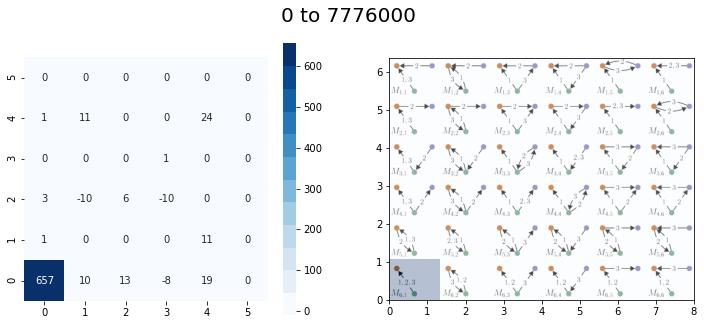

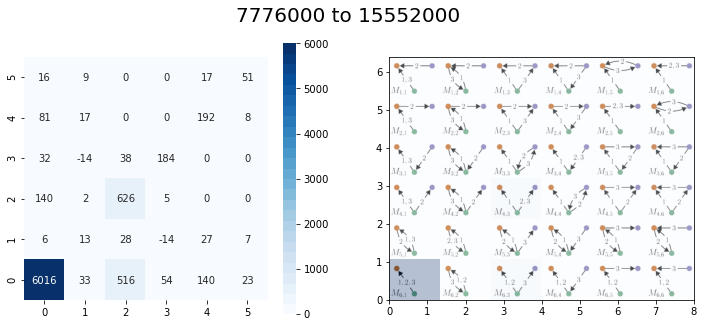

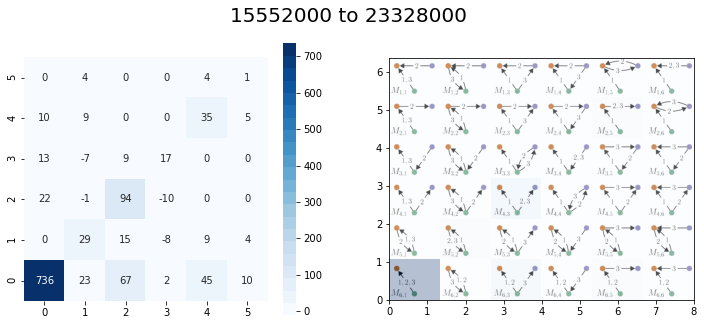

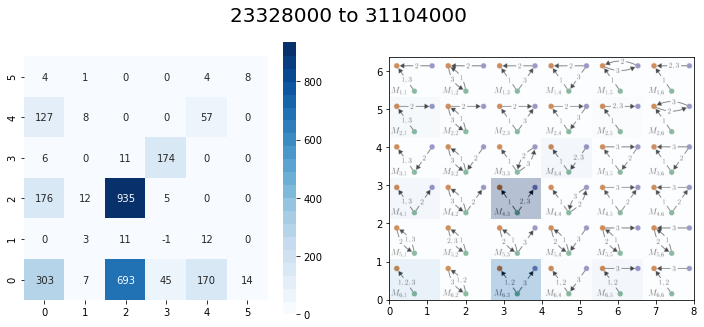

In [189]:
input_graph_path = "/home/aakyildiz/tokens/Rarible/Rarible.edgelist"
time_period = 60*60*24*90 # 90 day periods 
evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=60)